In [1]:
pip install imbalanced-learn

     |████████████████████████████████| 167 kB 4.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [98]:
import pandas as pd
url="https://bd29ee0e-54ab-4daa-9671-d153865d1620.usrfiles.com/ugd/bd29ee_432dd80c81fe44369ef5acdda0543239.csv"
df=pd.read_csv(url,header=None,na_values=["?"])
df.head()

,0,1,2,3,4,5,6,7,8
0,mid,low,excellent,mid,stable,stable,stable,15.0,A
1,mid,high,excellent,high,stable,stable,stable,10.0,S
2,high,low,excellent,high,stable,stable,mod-stable,10.0,A
3,mid,low,good,high,stable,unstable,mod-stable,15.0,A
4,mid,mid,excellent,high,stable,stable,stable,10.0,A


In [99]:
df.shape

(90, 9)

In [100]:
df.isna().any()

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7     True
8    False
dtype: bool

In [101]:
df.mode()

,0,1,2,3,4,5,6,7,8
0,mid,mid,good,mid,stable,stable,stable,10.0,A
1,NaN,NaN,NaN,NaN,unstable,NaN,NaN,NaN,NaN


In [102]:
df=df.fillna(10)
df.isna().any()

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
dtype: bool

In [103]:
df=df.rename(columns={8:"Class"})
y=df[["Class"]]
y.head()

,Class
0,A
1,S
2,A
3,A
4,A


In [104]:
y.groupby("Class")["Class"].count()

Class
A     63
A      1
I      2
S     24
Name: Class, dtype: int64

In [105]:
import numpy as np
np.unique(y)

array(['A', 'A ', 'I', 'S'], dtype=object)

In [106]:
y=y.replace(['A '],['A'])

y.groupby("Class")["Class"].count()

Class
A    64
I     2
S    24
Name: Class, dtype: int64

In [107]:
X_sub=df.iloc[:,0:7]
X_sub.head()

,0,1,2,3,4,5,6
0,mid,low,excellent,mid,stable,stable,stable
1,mid,high,excellent,high,stable,stable,stable
2,high,low,excellent,high,stable,stable,mod-stable
3,mid,low,good,high,stable,unstable,mod-stable
4,mid,mid,excellent,high,stable,stable,stable


In [108]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
X_sub=X_sub.apply(le.fit_transform)
X_sub.head()

,0,1,2,3,4,5,6
0,2,1,0,2,0,1,1
1,2,0,0,0,0,1,1
2,0,1,0,0,0,1,0
3,2,1,1,0,0,2,0
4,2,2,0,0,0,1,1


In [109]:
level=pd.DataFrame(df.iloc[:,7])
level.head()

,7
0,15.0
1,10.0
2,10.0
3,15.0
4,10.0


In [110]:
X=pd.concat([X_sub,level],axis=1)
X.head()

,0,1,2,3,4,5,6,7
0,2,1,0,2,0,1,1,15.0
1,2,0,0,0,0,1,1,10.0
2,0,1,0,0,0,1,0,10.0
3,2,1,1,0,0,2,0,15.0
4,2,2,0,0,0,1,1,10.0


In [111]:
import numpy as np
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# feature extraction. We are going to output the selection scores for all features and select the features with the highest scores.
test = SelectKBest(score_func=f_classif, k="all")
fit = test.fit(X, np.asarray(y).reshape(y.shape[0],))
features = fit.transform(X)
# summarize scores
set_printoptions(precision=3)

scores=fit.scores_
scores=pd.DataFrame(scores)
scores=scores.rename(columns={0:"scores"})
scores=scores.sort_values(by=["scores"],ascending=False)
scores

,scores
5,1.058730
2,0.985009
3,0.794737
6,0.497699
1,0.407791
7,0.162138
0,0.000000
4,0.000000


In [112]:
X_scores=scores[scores["scores"]>0.45]
len(X_scores)

4

In [113]:
Xp=X.iloc[:,X_scores.index]
Xp.head()

,5,2,3,6
0,1,0,2,1
1,1,0,0,1
2,1,0,0,0
3,2,1,0,0
4,1,0,0,1


In [114]:
Xp=Xp+1
Xp.head()

,5,2,3,6
0,2,1,3,2
1,2,1,1,2
2,2,1,1,1
3,3,2,1,1
4,2,1,1,2


In [115]:
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

In [116]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

model = OneVsRestClassifier(RandomForestClassifier(n_estimators=150,random_state=0),n_jobs=-1)
scores=cross_val_score(model,Xp,np.asarray(y).reshape(y.shape[0],),cv=4)
print("Accuracy: ",scores.mean(),"+/-",scores.std())

/srv/conda/envs/notebook/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)


Accuracy:  0.7223320158102766 +/- 0.03596892237786818


In [117]:
y_pred = cross_val_predict(model, Xp,np.asarray(y).reshape(y.shape[0],), cv=4)
print("Confusion matrix: \n",confusion_matrix(y,y_pred))

/srv/conda/envs/notebook/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)


Confusion matrix: 
 [[63  0  1]
 [ 2  0  0]
 [22  0  2]]


In [118]:
from sklearn.multiclass import OneVsOneClassifier
model = OneVsOneClassifier(RandomForestClassifier(n_estimators=150,random_state=0),n_jobs=-1)
scores=cross_val_score(model,Xp,np.asarray(y).reshape(y.shape[0],),cv=4)
print("Accuracy: ",scores.mean(),"+/-",scores.std())

/srv/conda/envs/notebook/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)


Accuracy:  0.7223320158102766 +/- 0.03596892237786818


In [119]:
y_pred = cross_val_predict(model, Xp,np.asarray(y).reshape(y.shape[0],), cv=4)
print("Confusion matrix: \n",confusion_matrix(y,y_pred))

/srv/conda/envs/notebook/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)


Confusion matrix: 
 [[63  0  1]
 [ 2  0  0]
 [22  0  2]]


In [120]:
Forest=RandomForestClassifier(random_state=0)
scores=cross_val_score(Forest,Xp,np.asarray(y).reshape(y.shape[0],),cv=4)
print("Accuracy: ",scores.mean(),"+/-",scores.std())

/srv/conda/envs/notebook/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)


Accuracy:  0.7223320158102766 +/- 0.03596892237786818


In [121]:
y_pred = cross_val_predict(Forest, Xp,np.asarray(y).reshape(y.shape[0],), cv=4)
print("Confusion matrix: \n",confusion_matrix(y,y_pred))

/srv/conda/envs/notebook/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)


Confusion matrix: 
 [[63  0  1]
 [ 2  0  0]
 [22  0  2]]


#### Drop the class with only 2 instances.

In [122]:
df=pd.concat([X,y],axis=1)
df.head()

,0,1,2,3,4,5,6,7,Class
0,2,1,0,2,0,1,1,15.0,A
1,2,0,0,0,0,1,1,10.0,S
2,0,1,0,0,0,1,0,10.0,A
3,2,1,1,0,0,2,0,15.0,A
4,2,2,0,0,0,1,1,10.0,A


In [123]:
df3=df[df["Class"]=="I"]
df3

,0,1,2,3,4,5,6,7,Class
46,1,2,1,0,1,1,1,10.0,I
82,2,1,1,2,0,1,2,10.0,I


In [124]:
df=df.drop(index=[46,82])
df.shape

(88, 9)

In [125]:
y=df[["Class"]]
y.groupby("Class")["Class"].count()

Class
A    64
S    24
Name: Class, dtype: int64

In [126]:
X=df.drop(["Class"],axis=1)
X.head()

,0,1,2,3,4,5,6,7
0,2,1,0,2,0,1,1,15.0
1,2,0,0,0,0,1,1,10.0
2,0,1,0,0,0,1,0,10.0
3,2,1,1,0,0,2,0,15.0
4,2,2,0,0,0,1,1,10.0


In [127]:
fit = test.fit(X, np.asarray(y).reshape(y.shape[0],))
features = fit.transform(X)
# summarize scores
set_printoptions(precision=3)

scores=fit.scores_
scores=pd.DataFrame(scores)
scores=scores.rename(columns={0:"scores"})
scores=scores.sort_values(by=["scores"],ascending=False)
scores

,scores
5,2.010390
3,1.403097
1,0.733933
2,0.118682
6,0.060665
7,0.001424
0,0.000000
4,0.000000


In [128]:
X_scores=scores[scores["scores"]>0.1]
len(X_scores)

4

In [129]:
Xp=X.iloc[:,X_scores.index]
Xp.head()

,5,3,1,2
0,1,2,1,0
1,1,0,0,0
2,1,0,1,0
3,2,0,1,1
4,1,0,2,0


In [130]:
Forest=RandomForestClassifier(random_state=0)
scores=cross_val_score(Forest,Xp,np.asarray(y).reshape(y.shape[0],),cv=4)
print("Accuracy: ",scores.mean(),"+/-",scores.std())

Accuracy:  0.6818181818181819 +/- 0.03214121732666126


In [131]:
y_pred = cross_val_predict(Forest, Xp,np.asarray(y).reshape(y.shape[0],), cv=4)
print("Confusion matrix: \n",confusion_matrix(y,y_pred))

Confusion matrix: 
 [[58  6]
 [22  2]]


In [132]:
from sklearn.ensemble import GradientBoostingClassifier
Gradient=GradientBoostingClassifier(learning_rate=0.001,random_state=0)
scores=cross_val_score(Gradient,Xp,np.asarray(y).reshape(y.shape[0],),cv=4)
print("Accuracy: ",scores.mean(),"+/-",scores.std())

Accuracy:  0.7272727272727273 +/- 0.0


In [133]:
y_pred = cross_val_predict(Gradient, Xp,np.asarray(y).reshape(y.shape[0],), cv=4)
print("Confusion matrix: \n",confusion_matrix(y,y_pred))

Confusion matrix: 
 [[64  0]
 [24  0]]


In [134]:
from sklearn import svm
SVM=svm.SVC()
scores=cross_val_score(SVM,Xp,np.asarray(y).reshape(y.shape[0],),cv=9)
print("Accuracy: ",scores.mean(),"+/-",scores.std())

Accuracy:  0.7283950617283951 +/- 0.04060959062567541


In [135]:
y_pred = cross_val_predict(SVM, Xp,np.asarray(y).reshape(y.shape[0],), cv=9)
print("Confusion matrix: \n",confusion_matrix(y,y_pred))

Confusion matrix: 
 [[64  0]
 [24  0]]


In [136]:
Xp=X.iloc[:,X_scores.index]

Xp.head()

,5,3,1,2
0,1,2,1,0
1,1,0,0,0
2,1,0,1,0
3,2,0,1,1
4,1,0,2,0


In [138]:
Xp=Xp.rename(columns={5:"Col5",3:"Col3",1:"Col1",2:"Col2"})
Xp.head()

,Col5,Col3,Col1,Col2
0,2,3,2,1
1,2,1,1,1
2,2,1,2,1
3,3,1,2,2
4,2,1,3,1


In [139]:
dfp=pd.concat([Xp,y],axis=1)
dfp.head()

,Col5,Col3,Col1,Col2,Class
0,2,3,2,1,A
1,2,1,1,1,S
2,2,1,2,1,A
3,3,1,2,2,A
4,2,1,3,1,A


In [140]:
ClassA=dfp[dfp["Class"]=="A"]
ClassA.head()

,Col5,Col3,Col1,Col2,Class
0,2,3,2,1,A
2,2,1,2,1,A
3,3,1,2,2,A
4,2,1,3,1,A
10,2,3,3,2,A


In [141]:
ClassS=dfp[dfp["Class"]=="S"]
ClassS.head()

,Col5,Col3,Col1,Col2,Class
1,2,1,1,1,S
5,2,3,2,2,S
6,2,1,2,1,S
7,3,3,3,1,S
8,2,3,1,2,S


In [142]:
X_5A=ClassA[["Col5"]]
X_5S=ClassS[["Col5"]]

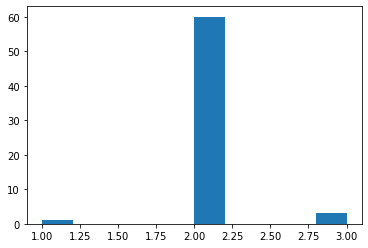

In [143]:
import matplotlib.pyplot as plt
plt.hist(X_5A)
plt.show()

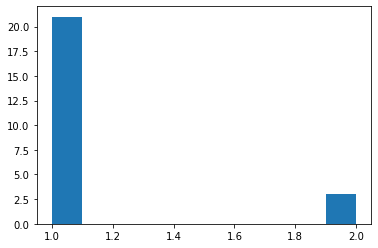

In [57]:
plt.hist(X_5S)
plt.show()

In [58]:
X_3A=ClassA[["Col3"]]
X_3S=ClassS[["Col3"]]

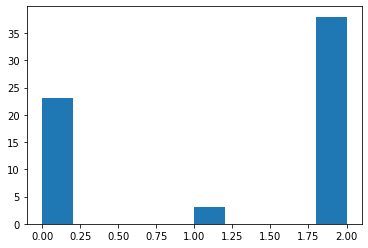

In [59]:
plt.hist(X_3A)
plt.show()

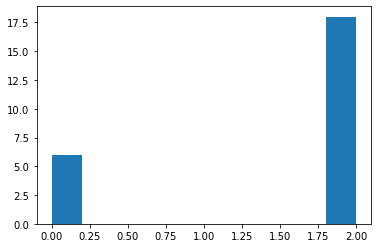

In [60]:
plt.hist(X_3S)
plt.show()

In [61]:
X_1A=ClassA[["Col1"]]
X_1S=ClassS[["Col1"]]

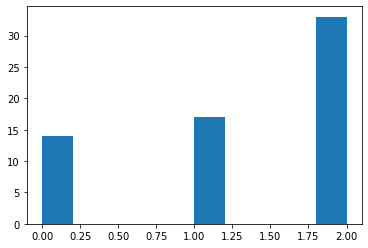

In [62]:
plt.hist(X_1A)
plt.show()

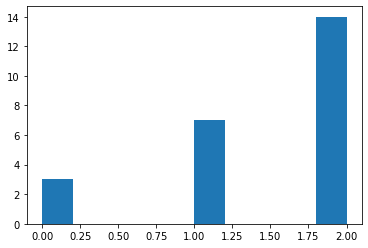

In [63]:
plt.hist(X_1S)
plt.show()

In [64]:
X_2A=ClassA[["Col2"]]
X_2S=ClassS[["Col2"]]

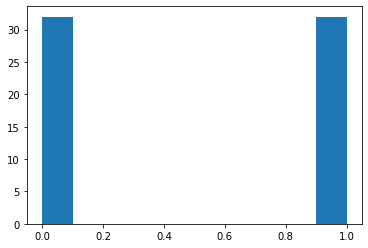

In [65]:
#plt.hist(np.log(X_2A+3))
plt.hist(X_2A)
plt.show()

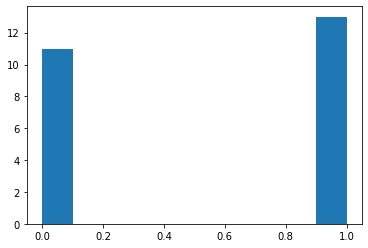

In [66]:
#plt.hist(np.log(X_2S+3))
plt.hist(X_2S)
plt.show()

In [176]:
Col5=Xp[["Col5"]]

SVM=svm.SVC(kernel="sigmoid")
scores=cross_val_score(SVM,Col5,np.asarray(y).reshape(y.shape[0],),cv=7)
print("Accuracy: ",scores.mean(),"+/-",scores.std())

Accuracy:  0.7280219780219781 +/- 0.03156353102493424


In [177]:
y_pred = cross_val_predict(SVM, Col5,np.asarray(y).reshape(y.shape[0],), cv=7)
print("Confusion matrix: \n",confusion_matrix(y,y_pred))

Confusion matrix: 
 [[64  0]
 [24  0]]


In [193]:
Gradient=GradientBoostingClassifier(learning_rate=0.005,random_state=0)
scores=cross_val_score(Gradient,Col5,np.asarray(y).reshape(y.shape[0],),cv=4)
print("Accuracy: ",scores.mean(),"+/-",scores.std())

Accuracy:  0.7272727272727273 +/- 0.0
